# Using CellTypist for cell type classification
This is an edited notebook. Original workflow can be found here: https://colab.research.google.com/github/Teichlab/celltypist/blob/main/docs/notebook/celltypist_tutorial.ipynb

Following steps will install the

## Install CellTypist

In [ ]:
!pip install celltypist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.3 MB/s eta 0:00:00


In [ ]:
import scanpy as sc

In [ ]:
import celltypist
from celltypist import models

## Download a scRNA-seq dataset of 2,000 immune cells

In [ ]:
adata_2000 = sc.read("Cosmx_anndata.h5ad")

This dataset includes 2,000 cells and 18,950 genes collected from different studies, thereby showing the practical applicability of CellTypist.

In [ ]:
adata_2000.shape

(241008, 960)

The expression matrix (`adata_2000.X`) is pre-processed (and required) as log1p normalised expression to 10,000 counts per cell (this matrix can be alternatively stashed in `.raw.X`).

In [ ]:
adata_2000.X.expm1().sum(axis = 1)

matrix([[10000.   ],
        [10000.002],
        [ 9999.999],
        ...,
        [ 9999.998],
        [10000.   ],
        [ 9999.999]], dtype=float32)

Some pre-assigned cell type labels are also in the data, which will be compared to the predicted labels from CellTypist later.

In [ ]:
adata_2000.obs

fov  Area  AspectRatio  CenterX_global_px  CenterY_global_px  Width  \
2_1_0       1  4191         2.20        1913.333333      140378.555556    112   
3_1_0       1  4566         0.97        2157.333333      140364.555556     76   
4_1_0       1  4288         1.48        2350.333333      140372.555556     92   
5_1_0       1  1118         1.52        2483.333333      140387.555556     50   
6_1_0       1  1708         1.33        2526.333333      140382.555556     56   
...        ..   ...          ...                ...                ...    ...   
3040_45_1  45  1854         2.39        4274.888889         339.222222     74   
3041_45_1  45   775         1.87        4325.888889         335.222222     43   
3042_45_1  45  1629         3.42        3206.888889         335.222222     82   
3043_45_1  45   545         3.40        6480.888889         331.222222     51   
3044_45_1  45   642         4.14        7800.888889         330.222222     58   

           Height  Mean.MembraneStain  Max.MembraneStain  Mean.PanCK  ...  \
2_1_0          51                7377              16475        4133  ...   
3_1_0          78                9058              13283         700  ...   
4_1_0          62                8677              12168         702  ...   
5_1_0          33                9498              12022         678  ...   
6_1_0          42               10476              14461        3239  ...   
...           ...                 ...                ...         ...  ...   
3040_45_1      31               14434              31918         611  ...   
3041_45_1      23               17157              31514         555  ...   
3042_45_1      24               33971              63567       18165  ...   
3043_45_1      15               29605              41251        8258  ...   
3044_45_1      14               24018              44247        4194  ...   

           Mean.CD3  Max.CD3  Mean.DAPI  Max.DAPI  cell_ID      sample  \
2_1_0            79      335        332       942        2  Lung9_Rep1   
3_1_0           175      751        443      1814        3  Lung9_Rep1   
4_1_0           297     1292        643      1467        4  Lung9_Rep1   
5_1_0           297      901        386      1005        5  Lung9_Rep1   
6_1_0           155      690        563      2044        6  Lung9_Rep1   
...             ...      ...        ...       ...      ...         ...   
3040_45_1         4      306        773      1905     3040  Lung9_Rep2   
3041_45_1         0       23       1388      2701     3041  Lung9_Rep2   
3042_45_1         0        0        608      1859     3042  Lung9_Rep2   
3043_45_1         0        0        512      1091     3043  Lung9_Rep2   
3044_45_1         0        0        287       816     3044  Lung9_Rep2   

           n_counts  _scvi_batch _scvi_labels  cluster_cellcharter  
2_1_0            56            0            0                    2  
3_1_0            47            0            0                    2  
4_1_0            33            0            0                    2  
5_1_0             9            0            0                    5  
6_1_0            30            0            0                    5  
...             ...          ...          ...                  ...  
3040_45_1         3            0            0                    2  
3041_45_1         4            0            0                    2  
3042_45_1         4            0            0                    4  
3043_45_1         3            0            0                    4  
3044_45_1         5            0            0                    4  

[241008 rows x 23 columns]

## Assign cell type labels using a CellTypist built-in model
In this section, we show the procedure of transferring cell type labels from built-in models to the query dataset.

Download the latest CellTypist models.

In [ ]:
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = True)

All models are stored in `models.models_path`.

In [ ]:
models.models_path

'/root/.celltypist/data/models'

Get an overview of the models and what they represent.

In [ ]:
models.models_description()

model  \
0                        Immune_All_Low.pkl   
1                       Immune_All_High.pkl   
2                    Adult_COVID19_PBMC.pkl   
3   Adult_CynomolgusMacaque_Hippocampus.pkl   
4                       Adult_Human_MTG.pkl   
5           Adult_Human_PancreaticIslet.pkl   
6          Adult_Human_PrefrontalCortex.pkl   
7                      Adult_Human_Skin.pkl   
8                  Adult_Human_Vascular.pkl   
9                       Adult_Mouse_Gut.pkl   
10            Adult_Mouse_OlfactoryBulb.pkl   
11                Adult_Pig_Hippocampus.pkl   
12      Adult_RhesusMacaque_Hippocampus.pkl   
13                 Autopsy_COVID19_Lung.pkl   
14         COVID19_HumanChallenge_Blood.pkl   
15             COVID19_Immune_Landscape.pkl   
16                   Cells_Adult_Breast.pkl   
17                     Cells_Fetal_Lung.pkl   
18                   Cells_Human_Tonsil.pkl   
19               Cells_Intestinal_Tract.pkl   
20                    Cells_Lung_Airway.pkl   
21               Developing_Human_Brain.pkl   
22              Developing_Human_Gonads.pkl   
23         Developing_Human_Hippocampus.pkl   
24              Developing_Human_Organs.pkl   
25              Developing_Human_Thymus.pkl   
26               Developing_Mouse_Brain.pkl   
27         Developing_Mouse_Hippocampus.pkl   
28            Fetal_Human_AdrenalGlands.pkl   
29                 Fetal_Human_Pancreas.pkl   
30                Fetal_Human_Pituitary.pkl   
31                   Fetal_Human_Retina.pkl   
32                     Fetal_Human_Skin.pkl   
33                  Healthy_Adult_Heart.pkl   
34                 Healthy_COVID19_PBMC.pkl   
35                  Healthy_Human_Liver.pkl   
36                  Healthy_Mouse_Liver.pkl   
37          Human_AdultAged_Hippocampus.pkl   
38              Human_Colorectal_Cancer.pkl   
39           Human_Developmental_Retina.pkl   
40              Human_Embryonic_YolkSac.pkl   
41              Human_Endometrium_Atlas.pkl   
42                       Human_IPF_Lung.pkl   
43       Human_Longitudinal_Hippocampus.pkl   
44                     Human_Lung_Atlas.pkl   
45                        Human_PF_Lung.pkl   
46               Human_Placenta_Decidua.pkl   
47                  Lethal_COVID19_Lung.pkl   
48                  Mouse_Dentate_Gyrus.pkl   
49          Mouse_Isocortex_Hippocampus.pkl   
50         Mouse_Postnatal_DentateGyrus.pkl   
51                    Mouse_Whole_Brain.pkl   
52                   Nuclei_Lung_Airway.pkl   
53                      Pan_Fetal_Human.pkl   

                                          description  
0   immune sub-populations combined from 20 tissue...  
1   immune populations combined from 20 tissues of...  
2   peripheral blood mononuclear cell types from C...  
3   cell types from the hippocampus of adult cynom...  
4   cell types and subtypes (10x-based) from the a...  
5   cell types from pancreatic islets of healthy a...  
6   cell types and subtypes from the adult human d...  
7            cell types from human healthy adult skin  
8   vascular populations combined from multiple ad...  
9   cell types in the adult mouse gut combined fro...  
10   cell types from the olfactory bulb of adult mice  
11          cell types from the adult pig hippocampus  
12  cell types from the hippocampus of adult rhesu...  
13  cell types from the lungs of 16 SARS-CoV-2 inf...  
14  detailed blood cell states from 16 individuals...  
15  immune subtypes from lung and blood of COVID-1...  
16             cell types from the adult human breast  
17    cell types from human embryonic and fetal lungs  
18      tonsillar cell types from humans (3-65 years)  
19  intestinal cells from fetal, pediatric (health...  
20  cell populations from scRNA-seq of five locati...  
21  cell types from the first-trimester developing...  
22  cell types of human gonadal and adjacent extra...  
23   cell types from the developing human hippocampus  
24  cell types of five endoderm-derived organs in ..

Choose the model you want to employ, for example, the model with all tissues combined containing low-hierarchy (high-resolution) immune cell types/subtypes.

Transfer cell type labels from this model to the query dataset using [celltypist.annotate](https://celltypist.readthedocs.io/en/latest/celltypist.annotate.html).

In [ ]:
adata_2000.X = adata_2000.layers["counts"].copy()

# Normalize to 10,000
sc.pp.normalize_total(adata_2000, target_sum=1e4)

# Log1p
sc.pp.log1p(adata_2000)

By default (`majority_voting = False`), CellTypist will infer the identity of each query cell independently. This leads to raw predicted cell type labels, and usually finishes within seconds or minutes depending on the size of the query data. You can also turn on the majority-voting classifier (`majority_voting = True`), which refines cell identities within local subclusters after an over-clustering approach at the cost of increased runtime.

Compared to `adata_2000`, the new `adata` has additional prediction information in `adata.obs` (`predicted_labels`, `over_clustering`, `majority_voting` and `conf_score`). Of note, all these columns can be prefixed with a specific string by setting `prefix` in [to_adata](https://celltypist.readthedocs.io/en/latest/celltypist.classifier.AnnotationResult.html#celltypist.classifier.AnnotationResult.to_adata).

Makes labels predictions for 3 models and adds them to adata object as separate columns in obs attribute.

In [ ]:

# Define your models and their acronyms for labeling
models = {
    "Immune_All_Low.pkl": "IAL",
    "Immune_All_High.pkl": "IAH",
    "Human_Lung_Atlas.pkl": "HLA"
}

# Loop through each model and annotate
for model_file, prefix in models.items():
    # Step 1: Annotate with the model
    preds = celltypist.annotate(
        adata_2000,
        model=model_file,
        majority_voting=False
    )

    # Step 2: Add only predicted labels to .obs with custom name
    adata = preds.to_adata(
        adata_2000,
        prefix=prefix,
        insert_conf=False
    )

In [ ]:
adata.write("Cosmx_anndata_typed.h5ad")

In addition to this meta information added, the neighborhood graph constructed during over-clustering is also stored in the `adata`
(If a pre-calculated neighborhood graph is already present in the `AnnData`, this graph construction step will be skipped).  
This graph can be used to derive the cell embeddings, such as the UMAP coordinates.

In [ ]:
# If the UMAP or any cell embeddings are already available in the `AnnData`, skip this command.
sc.tl.umap(adata)

Visualise the prediction results.

In [ ]:
subset = adata[adata.obs["IALpredicted_labels"].isin(['Type 1 helper T cells',
       'Type 17 helper T cells', 'gamma-delta T cells', 'Trm cytotoxic T cells','Treg(diff)','Tcm/Naive helper T cells',
       'Tem/Effector helper T cells', 'Tem/Effector helper T cells PD1+',
       'Tem/Temra cytotoxic T cells', 'Tem/Trm cytotoxic T cells','Tcm/Naive cytotoxic T cells','Regulatory T cells','Memory CD4+ cytotoxic T cells','Follicular helper T cells','Cycling gamma-delta T cells','Cycling T cells','CRTAM+ gamma-delta T cells'])]

In [ ]:
subset = subset[subset.obs["HLApredicted_labels"].isin(['B cells',
       'Basal resting', 'CD4 T cells', 'CD8 T cells'])]

In [ ]:
adata.write("Cosmx_anndata_typed_3models.h5ad")

In [ ]:
subset = subset[subset.obs["IAHpredicted_labels"].isin(['T cells'])]

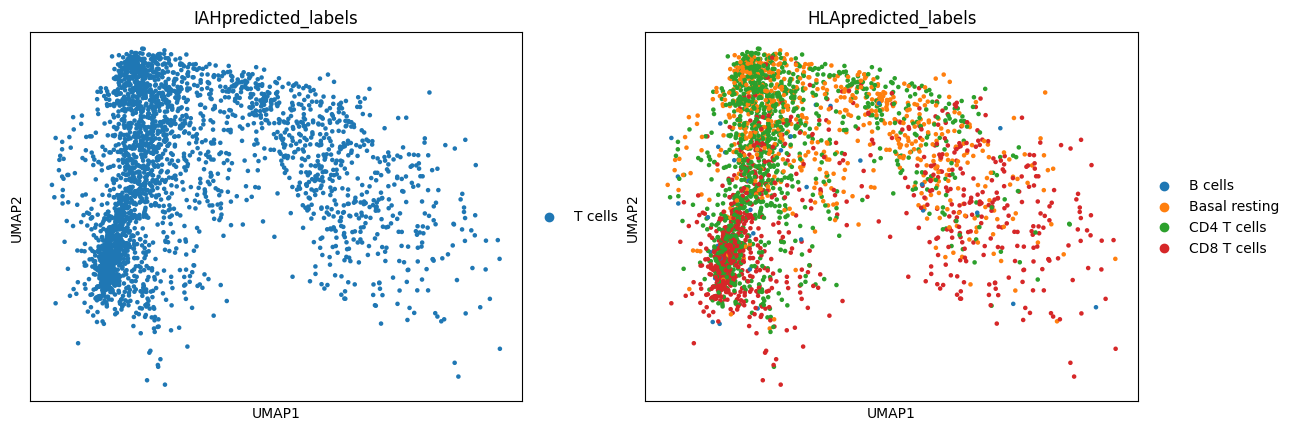

In [ ]:
sc.pl.umap(subset, color = ['IAHpredicted_labels','HLApredicted_labels'], legend_loc = 'right margin')

Actually, you may not need to explicitly convert `predictions` output by `celltypist.annotate` into an `AnnData` as above. A more useful way is to use the visualisation function [celltypist.dotplot](https://celltypist.readthedocs.io/en/latest/celltypist.dotplot.html), which quantitatively compares the CellTypist prediction result (e.g. `majority_voting` here) with the cell types pre-defined in the `AnnData` (here `cell_type`). You can also change the value of `use_as_prediction` to `predicted_labels` to compare the raw prediction result with the pre-defined cell types.

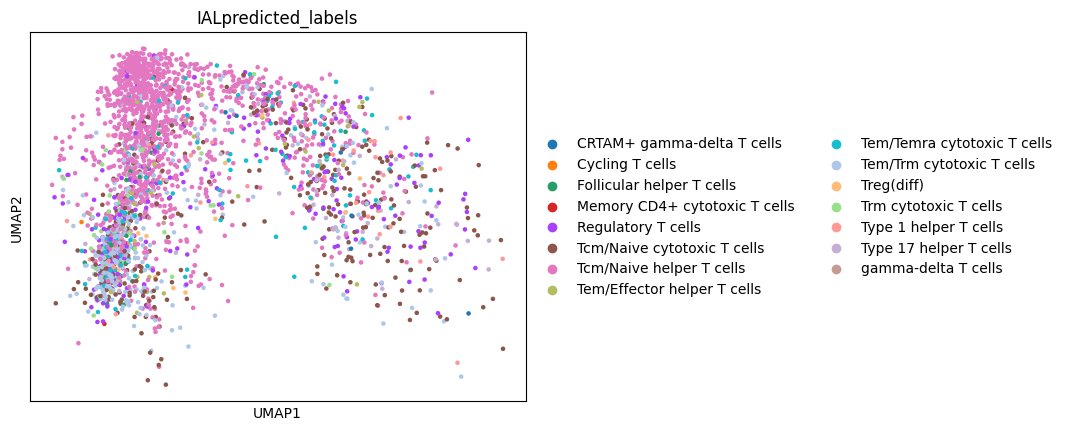

In [ ]:
sc.pl.umap(subset, color = ['IALpredicted_labels'], legend_loc = 'right margin')